## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [3]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [4]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [5]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=r"data/hotdog_nothotdog"):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [6]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), #squishing image to a square
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0) #3 doesnt work
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

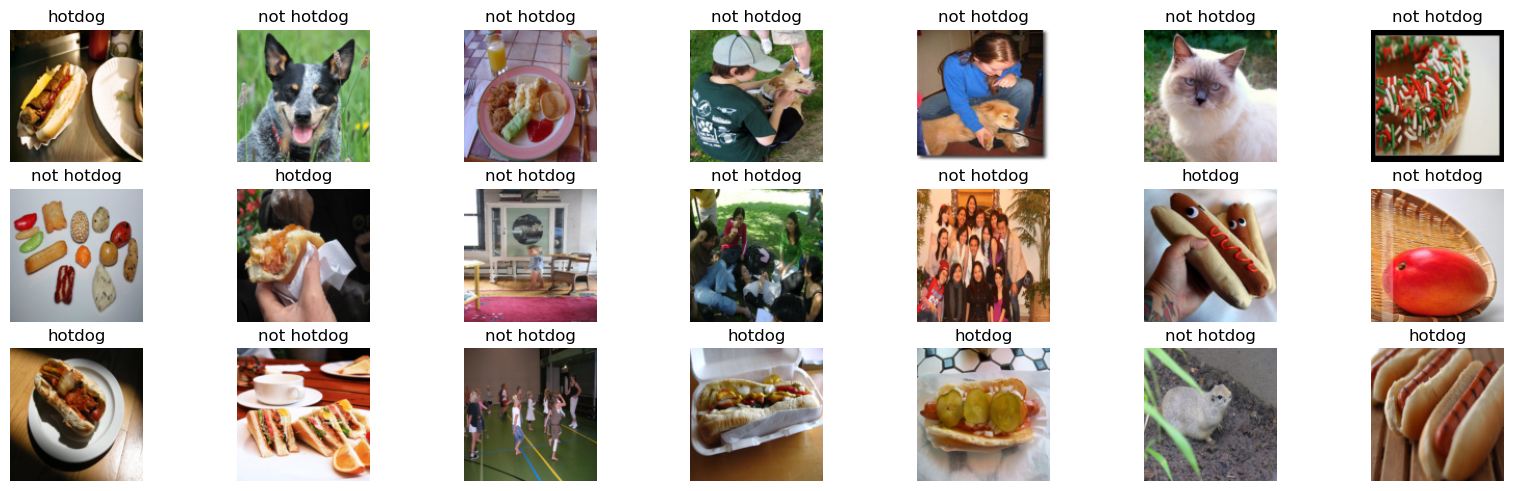

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
class HotdogCNN(nn.Module):
    def __init__(self, dropout=0.2):
        super(HotdogCNN, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # 3 input channels; padding 1 to get full image
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),model.eval()
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64×64 to 32×32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 64×64 to 32×32
        )

        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(32 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 2)   # 2 classes: hotdog / not hotdog
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.classifier(x)
        return x


In [9]:
def get_optimizer(model, name="adam", lr=1e-3, weight_decay=0.0):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # "adam" default


In [10]:

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += nn.CrossEntropyLoss()(logits, y).item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total)


Run best model again to extract train and validation plot

In [11]:
model = HotdogCNN(dropout=0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model,
                            "admaw",
                            lr=0.0001,
                            weight_decay=0.0001)

tr_loss_arr = np.zeros(10)
tr_acc_arr = np.zeros(10)
va_loss_arr = np.zeros(10)
va_acc_arr = np.zeros(10)

for ep in range(10):
    print(f"started Ep {ep:02d}")
    tr_loss_arr[ep], tr_acc_arr[ep] = train_one_epoch(model, train_loader, criterion, optimizer)
    va_loss_arr[ep], va_acc_arr[ep] = eval_epoch(model, test_loader) 
    print(f"Ep {ep:02d} | train {tr_acc_arr[ep]*100:.1f}% ({tr_loss_arr[ep]:.4f}) | val {va_acc_arr[ep]*100:.1f}% ({va_loss_arr[ep]:.4f})")
    

started Ep 00
Ep 00 | train 66.4% (0.6072) | val 61.7% (0.6637)
started Ep 01
Ep 01 | train 78.1% (0.4700) | val 67.6% (0.6461)
started Ep 02
Ep 02 | train 80.8% (0.4113) | val 74.0% (0.5467)
started Ep 03
Ep 03 | train 83.0% (0.3743) | val 73.0% (0.5452)
started Ep 04
Ep 04 | train 85.1% (0.3425) | val 74.6% (0.5419)
started Ep 05
Ep 05 | train 88.2% (0.2889) | val 75.0% (0.5386)
started Ep 06
Ep 06 | train 91.2% (0.2472) | val 75.0% (0.5539)
started Ep 07
Ep 07 | train 93.0% (0.2171) | val 74.9% (0.5705)
started Ep 08
Ep 08 | train 94.0% (0.1910) | val 71.8% (0.6314)
started Ep 09
Ep 09 | train 93.5% (0.1853) | val 75.1% (0.5712)


save the model

In [12]:
# Save
torch.save(model.state_dict(), "models/hotdog_model_adamw_lr0_0001_wd0_0001.pth")

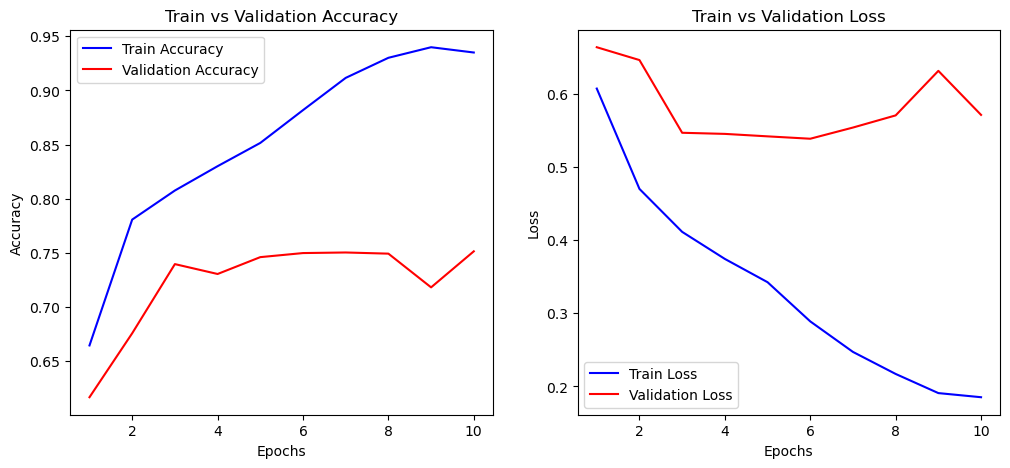

In [17]:
epochs = range(1, len(tr_acc_arr) + 1)

# ---- Plot Accuracy ----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc_arr, 'b-', label="Train Accuracy")
plt.plot(epochs, va_acc_arr, 'r-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

# ---- Plot Loss ----
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss_arr, 'b-', label="Train Loss")
plt.plot(epochs, va_loss_arr, 'r-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.savefig("val_vs_acc_plot.png")
plt.show()

In [18]:
print(model)

HotdogCNN(
  (convolutional): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Saliency Map (Grad-CAM)

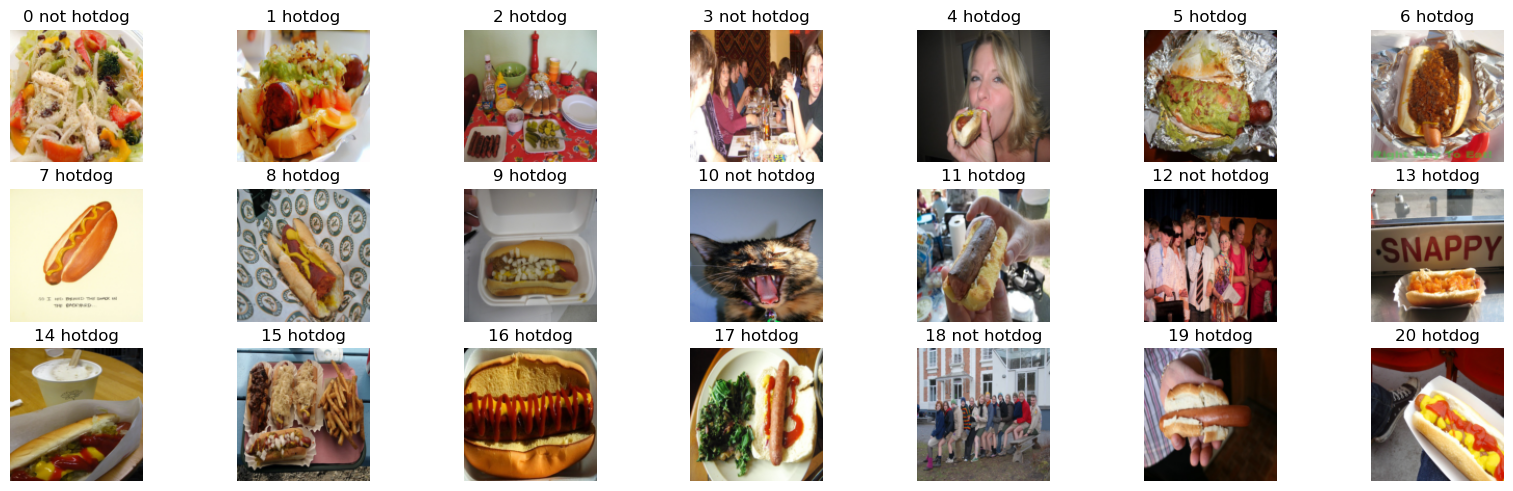

In [75]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title([str(i) + ' hotdog', str(i) + ' not hotdog'][labels[i].item()])
    plt.axis('off')


In [76]:
index = 4
# Convert to [H, W, C] and to numpy
input_img = images[index].permute(1, 2, 0).numpy()
input_img = np.clip(input_img, 0, 1)  # keep values in [0,1] for plotting
input_tensor = images[index].unsqueeze(0)
print(input_tensor.shape)

torch.Size([1, 3, 128, 128])


In [77]:
model.eval()
# Choose last conv layer
target_layer = model.convolutional[14]

# Store activations & gradients
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [78]:
# Forward pass
scores = model(input_tensor)
class_idx = scores.argmax(dim=1).item()

# Backward for chosen class
model.zero_grad()
scores[0, class_idx].backward()

# Get stored activations & gradients
acts = activations[0].detach()         # [B, C, H, W]
grads = gradients[0].detach()          # [B, C, H, W]

# Global average pooling over gradients
weights = grads.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]

# Weighted sum
cam = (weights * acts).sum(dim=1, keepdim=True)  # [B, 1, H, W]
cam = F.relu(cam)  # only positive values

# Normalize CAM
cam = cam.squeeze().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min())


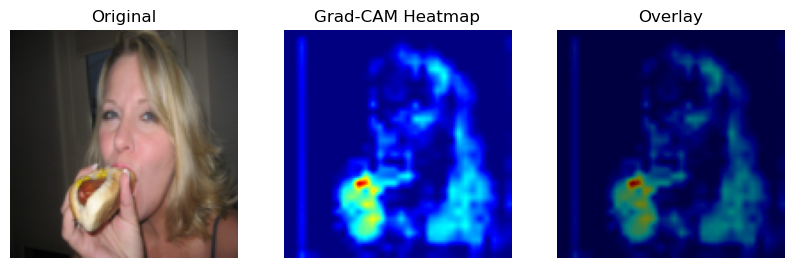

In [80]:
import cv2

# Resize CAM to image size
cam_resized = cv2.resize(cam, (input_img.shape[0], input_img.shape[1]))

# Convert heatmap to color
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Superimpose heatmap on original image
overlay = np.array(input_img) * 0.5 + heatmap * 0.5
overlay = overlay.astype(np.uint8)


# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.savefig("Grad-CAM-plot.png")
plt.show()

# Wrong vs right Classifications

In [69]:
wrong_images = []
wrong_preds = []
true_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:   # your val/test dataloader
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Find indices where prediction != label
        wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]
        
        for idx in wrong_idx:
            wrong_images.append(images[idx].cpu())
            wrong_preds.append(preds[idx].cpu().item())
            true_labels.append(labels[idx].cpu().item())


In [70]:
print(len(wrong_images), len(wrong_preds), len(true_labels))

45 45 45


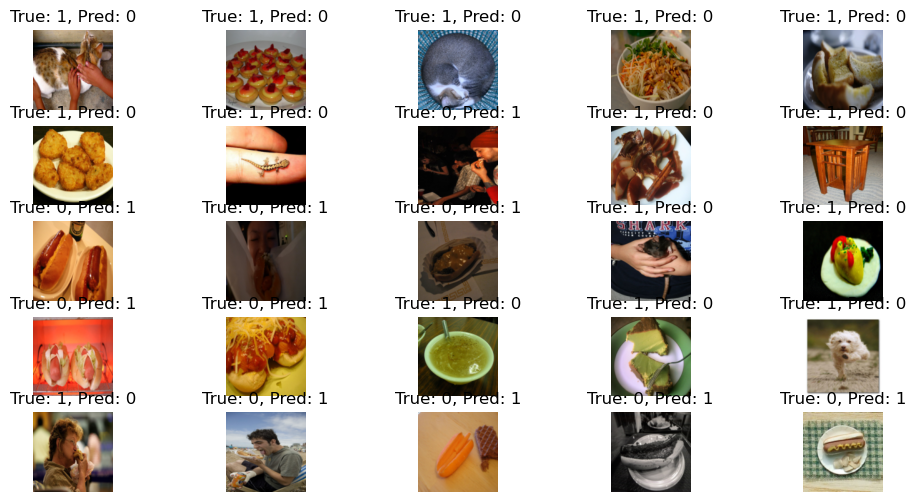

In [88]:

# Show all wrong predictions
n = 25
plt.figure(figsize=(12, 6))
for i in range(n):
    img = wrong_images[i].permute(1, 2, 0).numpy()

    plt.subplot(5,5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_labels[i]}, Pred: {wrong_preds[i]}")
    plt.axis("off")

plt.show()

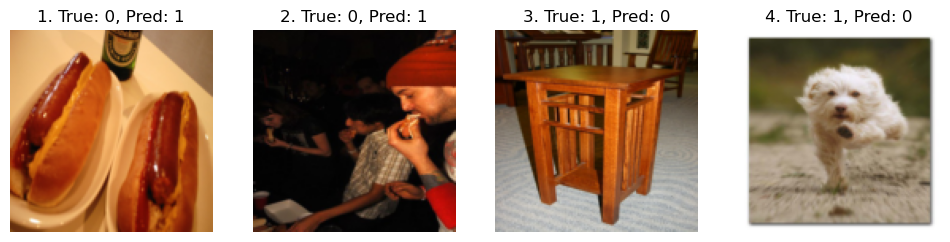

In [96]:
indices = [10, 7, 9, 19]

plt.figure(figsize=(12, 6))
for i in range(len(indices)):
    img = wrong_images[indices[i]].permute(1, 2, 0).numpy()

    plt.subplot(1,4, i+1)
    plt.imshow(img)
    plt.title(f"{i+1}. True: {true_labels[indices[i]]}, Pred: {wrong_preds[indices[i]]}")
    plt.axis("off")

plt.savefig("plots/wrong_classifications.png")
plt.show()